# Model Robustness

**Objectives**
- Load the Model(s)
- Run predictions on the model using the Holdout/Test Datasplit (better if the malicious samples are verified for malware types)
- Record instances where the model failed to predict correctly
- Record the performance of the models (e.g., Accuracy, Precision, Recall, ROC-AUC, etc.)

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import catboost as catb

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

from joblib import load
import warnings
warnings.filterwarnings("ignore")

## 1. Determine the Model Performance in each of the GBDT Models and each of its two behavior-types.

`How does the model perform using 'real-world' data (i.e., Test/Holdout Split)?`

Run other metrics as well as you see fit that are not found in the classification_report and Confusion Matrix.

- Label column is `0/'malicious'`
- Feature column is `[:, 1:101]`

### 1.1 Defining a helper function for evaluation


In [52]:
def evaluate(model, test_set, y_actual):
    y_pred = model.predict(test_set)
    cm = confusion_matrix(y_actual, y_pred)
    print(classification_report(y_actual, y_pred, digits=4))
    print(f"AUC-ROC Score: {roc_auc_score(y_actual, y_pred):.4f}")
    print("ROC Curve & Confusion matrix:")
    RocCurveDisplay.from_predictions(y_actual, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    #print(classification_report(y_actual, y_pred, digits=4))
    

### 1.2 LightGBM

In [53]:
DF_LGBM_TB = pd.read_csv('Dataset/LGBM_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_LGBM_IB = pd.read_csv('Dataset/LGBM_IB_Test.csv', low_memory=False)

display(DF_LGBM_TB.head())
print(DF_LGBM_TB['type'].unique())
display(DF_LGBM_IB.head())
print(DF_LGBM_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,172,117,110,60,81,60,81,60,81,...,35,117,208,240,117,208,117,35,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,208,286,76,110,240,117,208,187,208,...,81,60,81,225,35,225,208,76,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,3077863534c104b386a06484b8cf4672,trojan
3,1,82,208,187,208,172,117,172,117,172,...,159,82,215,109,201,45,160,159,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,82,240,117,240,117,240,117,240,117,...,215,141,65,112,20,34,215,248,e75e6cee4ad187356938cc06667222b5,adware


['trojan' 'adware' 'ransomware' 'pua' 'downloader' 'hacktool' 'benign'
 'miner' 'virus']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,172,117,110,60,81,228,274,158,215,...,307,307,307,307,307,307,307,307,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,208,286,76,110,240,117,187,198,228,...,307,307,307,307,307,307,307,307,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,3077863534c104b386a06484b8cf4672,trojan
3,1,82,208,187,172,117,16,240,31,20,...,307,307,307,307,307,307,307,307,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,82,240,117,172,16,31,86,112,122,...,307,307,307,307,307,307,307,307,e75e6cee4ad187356938cc06667222b5,adware


['trojan' 'adware' 'ransomware' 'pua' 'downloader' 'hacktool' 'benign'
 'miner' 'virus']


In [54]:
# Load trained LightGBM model files
default_tb = load('Models/LGBM/Default/RYZEN2b_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Default/RYZEN2b_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Tuned/TUNED_RYZEN2b_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Tuned/TUNED_RYZEN2b_LGBM_IB.model')

1. Default LGBM TB

              precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        10
           1     0.9935    1.0000    0.9968       461

    accuracy                         0.9936       471
   macro avg     0.9968    0.8500    0.9101       471
weighted avg     0.9937    0.9936    0.9931       471

AUC-ROC Score: 0.8500
ROC Curve & Confusion matrix:


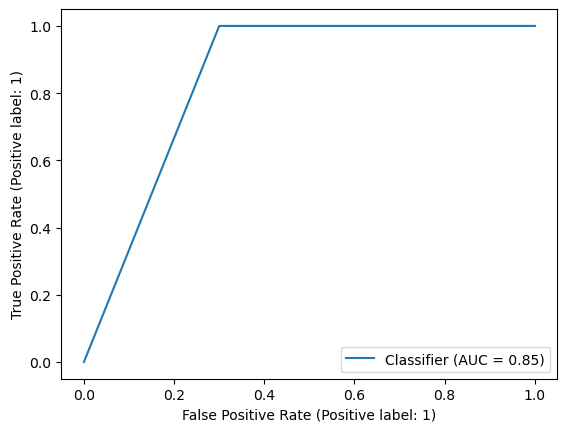

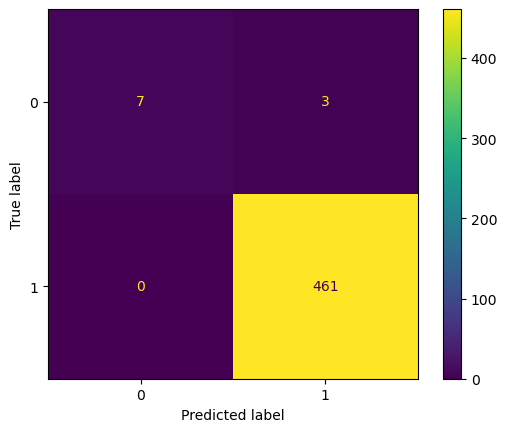

In [55]:
print("1. Default LGBM TB\n")
evaluate(default_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

2. Default LGBM IB

              precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        10
           1     0.9935    1.0000    0.9968       461

    accuracy                         0.9936       471
   macro avg     0.9968    0.8500    0.9101       471
weighted avg     0.9937    0.9936    0.9931       471

AUC-ROC Score: 0.8500
ROC Curve & Confusion matrix:


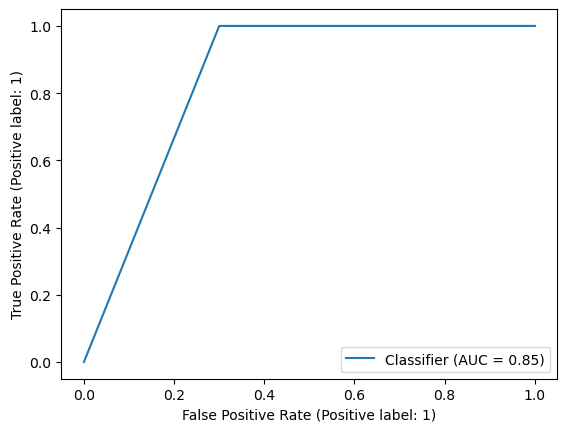

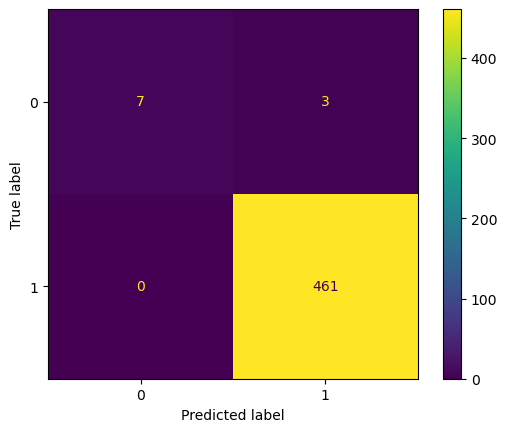

In [56]:
print("2. Default LGBM IB\n")
evaluate(default_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

3. Tuned LGBM TB

              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        10
           1     0.9957    1.0000    0.9978       461

    accuracy                         0.9958       471
   macro avg     0.9978    0.9000    0.9434       471
weighted avg     0.9958    0.9958    0.9955       471

AUC-ROC Score: 0.9000
ROC Curve & Confusion matrix:


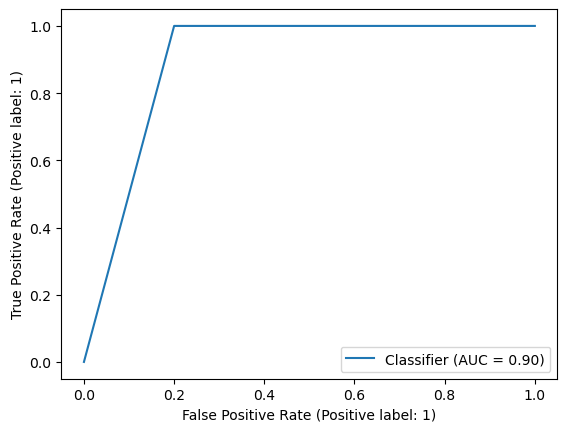

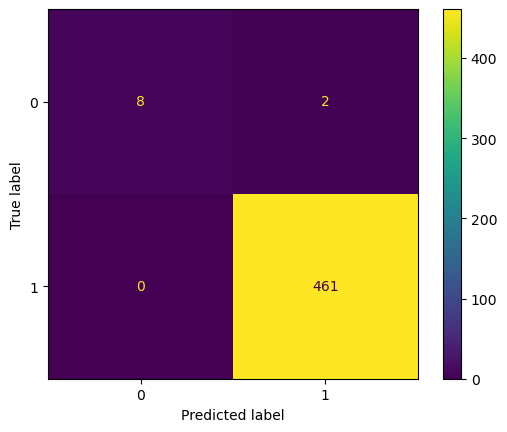

In [57]:
print("3. Tuned LGBM TB\n")
evaluate(tuned_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

4. Tuned LGBM IB

              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        10
           1     0.9957    1.0000    0.9978       461

    accuracy                         0.9958       471
   macro avg     0.9978    0.9000    0.9434       471
weighted avg     0.9958    0.9958    0.9955       471

AUC-ROC Score: 0.9000
ROC Curve & Confusion matrix:


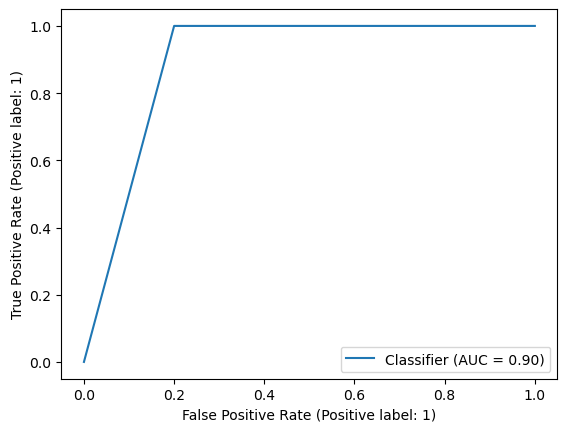

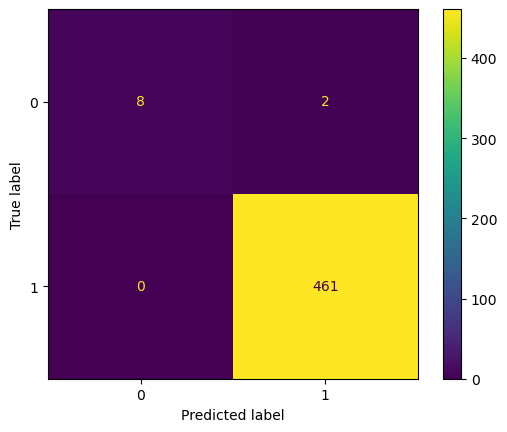

In [58]:
print("4. Tuned LGBM IB\n")
evaluate(tuned_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

### 1.3 CatBoost

In [59]:
DF_CATB_TB = pd.read_csv('Dataset/CATB_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_CATB_IB = pd.read_csv('Dataset/CATB_IB_Test.csv', low_memory=False)

DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

#DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['Type 1'] != '_']
#DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['Type 1'] != '_']

display(DF_CATB_TB.head())
print(DF_CATB_TB['type'].unique())
display(DF_CATB_IB.head())
print(DF_CATB_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,LdrGetDllHandle,LdrGetProcedureAddress,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,...,GetSystemMetrics,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,...,LoadResource,FindResourceExW,LoadResource,DrawTextExW,GetSystemMetrics,DrawTextExW,NtAllocateVirtualMemory,LoadStringA,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,3077863534c104b386a06484b8cf4672,trojan
3,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,NtDelayExecution,GetSystemTimeAsFileTime,NtClose,socket,ioctlsocket,connect,select,NtDelayExecution,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,RegQueryValueExW,RegCloseKey,RegOpenKeyExA,NtOpenFile,NtQueryInformationFile,NtClose,SHGetFolderPathW,e75e6cee4ad187356938cc06667222b5,adware


['trojan' 'adware' 'ransomware' 'pua' 'downloader' 'hacktool' 'benign'
 'miner' 'virus']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,LdrGetDllHandle,LdrGetProcedureAddress,OleInitialize,FindResourceExW,LoadResource,NtProtectVirtualMemory,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtFreeVirtualMemory,GetSystemInfo,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3077863534c104b386a06484b8cf4672,trojan
3,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,LdrLoadDll,CoInitializeEx,NtOpenFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CoInitializeEx,NtCreateMutant,RegOpenKeyExA,CoInitializeSecurity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e75e6cee4ad187356938cc06667222b5,adware


['trojan' 'adware' 'ransomware' 'pua' 'downloader' 'hacktool' 'benign'
 'miner' 'virus']


In [60]:
# Load trained CatBoost model files (CatBoost requires instantiation before being able to load a trianed model file).
default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("Models/CATB/Default/RYZEN2b_CATB_TB.model", format='json') # <== Point these to the respective .model files
default_ib = default_ib.load_model("Models/CATB/Default/RYZEN2b_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("Models/CATB/Tuned/TUNED_RYZEN2b_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("Models/CATB/Tuned/TUNED_RYZEN2b_CATB_IB.model", format='json')

1. Default CatBoost TB

              precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        10
           1     0.9935    1.0000    0.9968       461

    accuracy                         0.9936       471
   macro avg     0.9968    0.8500    0.9101       471
weighted avg     0.9937    0.9936    0.9931       471

AUC-ROC Score: 0.8500
ROC Curve & Confusion matrix:


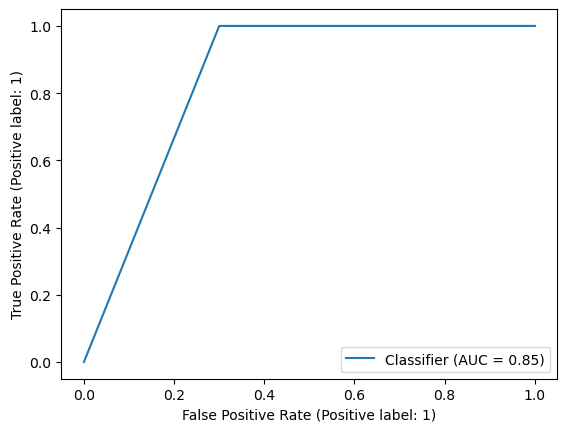

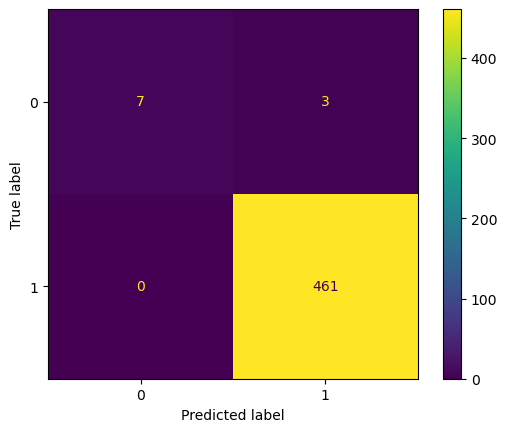

In [61]:
print("1. Default CatBoost TB\n")
evaluate(default_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

2. Default CatBoost IB

              precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        10
           1     0.9935    1.0000    0.9968       461

    accuracy                         0.9936       471
   macro avg     0.9968    0.8500    0.9101       471
weighted avg     0.9937    0.9936    0.9931       471

AUC-ROC Score: 0.8500
ROC Curve & Confusion matrix:


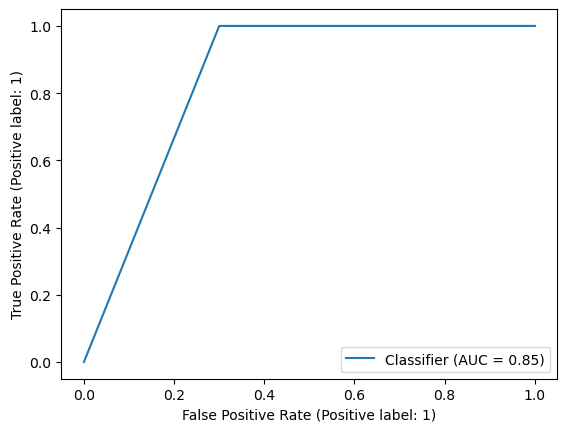

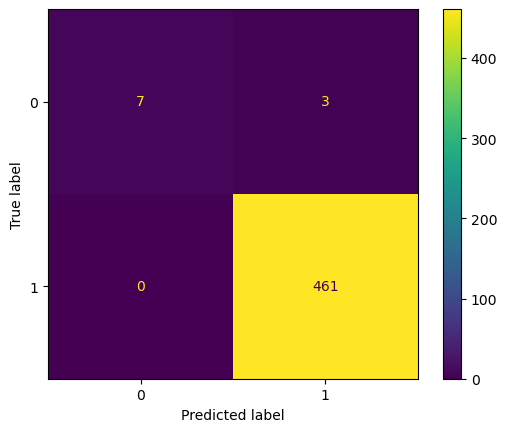

In [62]:
print("2. Default CatBoost IB\n")
evaluate(default_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

3. Tuned CatBoost TB

              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        10
           1     0.9957    1.0000    0.9978       461

    accuracy                         0.9958       471
   macro avg     0.9978    0.9000    0.9434       471
weighted avg     0.9958    0.9958    0.9955       471

AUC-ROC Score: 0.9000
ROC Curve & Confusion matrix:


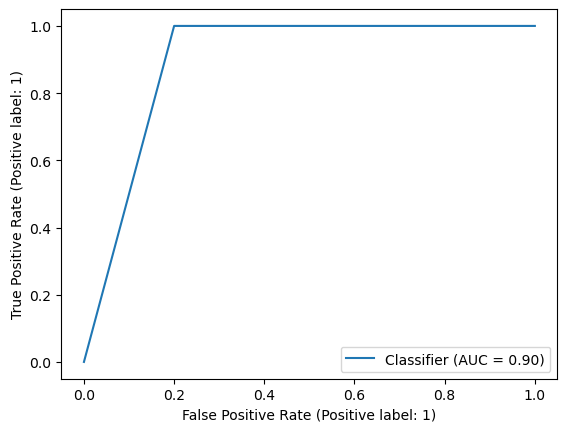

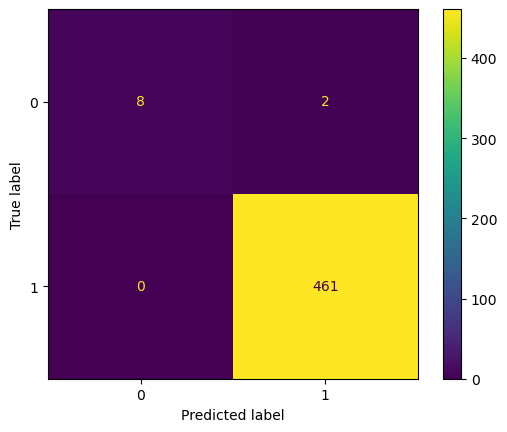

In [63]:
print("3. Tuned CatBoost TB\n")
evaluate(tuned_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

4. Tuned CatBoost IB

              precision    recall  f1-score   support

           0     1.0000    0.6000    0.7500        10
           1     0.9914    1.0000    0.9957       461

    accuracy                         0.9915       471
   macro avg     0.9957    0.8000    0.8728       471
weighted avg     0.9916    0.9915    0.9905       471

AUC-ROC Score: 0.8000
ROC Curve & Confusion matrix:


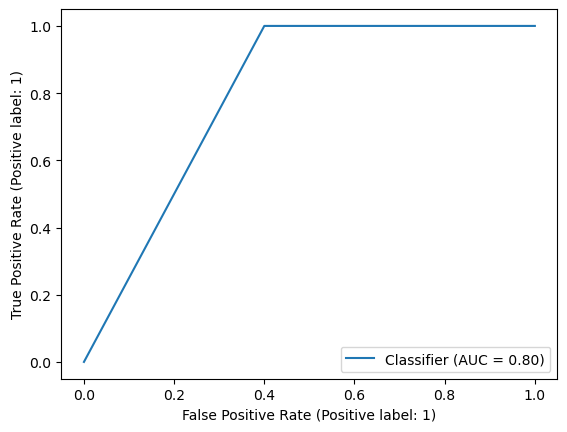

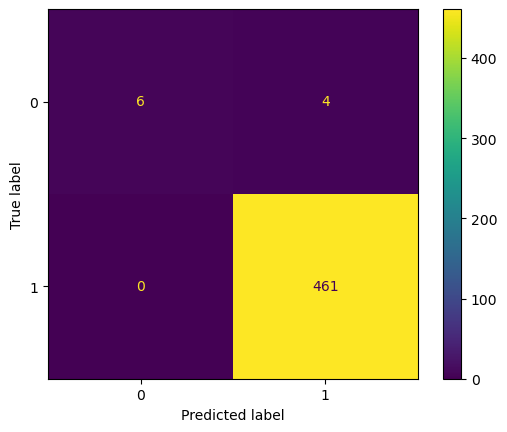

In [64]:
print("4. Tuned CatBoost IB\n")
evaluate(tuned_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

## 2. Check for model capabilities at a malware type level in each GBDT Models and each of its two behavior-types.

Using the `xx` dataset, determine the prediction capability of the model in each malware type.

**Answer this question:**

`How good are the model (as per classification report and confusion matrix) on a per-malware type basis?`

The theory is that malware-types that are prominent in terms of quantity might be detected accurately as malware than those that are not. 

### 2.1 Defining a helper function

In [65]:
def evaluate_per_type(model, test_set, mal_type):
    filtered_set = test_set.loc[(test_set['type'] == 'benign') | (test_set['type'] == mal_type)]
    y_pred = model.predict(filtered_set.iloc[:,1:101])
    acc = accuracy_score(filtered_set.iloc[:,0], y_pred)
    prec = precision_score(filtered_set.iloc[:,0], y_pred)
    rec = recall_score(filtered_set.iloc[:,0], y_pred)
    auc_roc = roc_auc_score(filtered_set.iloc[:,0], y_pred)
    f1 = f1_score(filtered_set.iloc[:,0], y_pred)
    cm = confusion_matrix(filtered_set.iloc[:,0], y_pred)
    print("Malware Type: " + mal_type)
    print("==========================")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc_roc:.4f}")
    print(f"TN: {cm[0,0]:4d} FN: {cm[1,0]:4d}")
    print(f"TP: {cm[1,1]:4d} FP: {cm[0,1]:4d}")
    print("")

### 2.1 LightGBM

In [66]:
#Load Verified Test/Holodut Dataset
DF_LGBM_TB = pd.read_csv('./Dataset/LGBM_TB_Test.csv', low_memory=False)
DF_LGBM_IB = pd.read_csv('./Dataset/LGBM_IB_Test.csv', low_memory=False)

# No need to drop these "_" muna, assume na walang false-labelled malicious samples (pa-comment out nalang muna).
# DF_LGBM_TB = DF_LGBM_TB[DF_LGBM_TB['type'] != '_']
# DF_LGBM_IB = DF_LGBM_IB[DF_LGBM_IB['type'] != '_']
DF_LGBM_TB = DF_LGBM_TB.dropna()
DF_LGBM_IB = DF_LGBM_IB.dropna()

#Models
default_tb = load('./Models/LGBM/Default/RYZEN2b_LGBM_TB.model')
default_ib = load('./Models/LGBM/Default/RYZEN2b_LGBM_IB.model')
tuned_tb = load('./Models/LGBM/Tuned/TUNED_RYZEN2b_LGBM_TB.model')
tuned_ib = load('./Models/LGBM/Tuned/TUNED_RYZEN2b_LGBM_IB.model')

display(DF_LGBM_TB)
print("DF_LGBM_TB:", DF_LGBM_TB['type'].unique().tolist())
display(DF_LGBM_IB)
print("DF_LGBM_IB:", DF_LGBM_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,172,117,110,60,81,60,81,60,81,...,35,117,208,240,117,208,117,35,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,208,286,76,110,240,117,208,187,208,...,81,60,81,225,35,225,208,76,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,3077863534c104b386a06484b8cf4672,trojan
3,1,82,208,187,208,172,117,172,117,172,...,159,82,215,109,201,45,160,159,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,82,240,117,240,117,240,117,240,117,...,215,141,65,112,20,34,215,248,e75e6cee4ad187356938cc06667222b5,adware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,ee56773db6ff7d6b0bd498417cd8b5f0,adware
467,1,286,110,172,240,117,240,117,240,117,...,65,117,260,297,215,114,215,71,9368836c52b7dce8d179d36436a00fc7,trojan
468,1,82,240,117,240,117,240,117,240,117,...,240,117,240,117,240,117,240,117,af587da66d2121ebd55b6ab4c05ce59b,trojan
469,1,82,172,117,16,208,171,239,172,117,...,208,264,252,119,187,215,297,34,7a79855483d136fbd4b65c8e4f74664a,trojan


DF_LGBM_TB: ['trojan', 'adware', 'ransomware', 'pua', 'downloader', 'hacktool', 'benign', 'miner', 'virus']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,172,117,110,60,81,228,274,158,215,...,307,307,307,307,307,307,307,307,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,208,286,76,110,240,117,187,198,228,...,307,307,307,307,307,307,307,307,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,3077863534c104b386a06484b8cf4672,trojan
3,1,82,208,187,172,117,16,240,31,20,...,307,307,307,307,307,307,307,307,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,82,240,117,172,16,31,86,112,122,...,307,307,307,307,307,307,307,307,e75e6cee4ad187356938cc06667222b5,adware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,ee56773db6ff7d6b0bd498417cd8b5f0,adware
467,1,286,110,172,240,117,106,171,260,141,...,307,307,307,307,307,307,307,307,9368836c52b7dce8d179d36436a00fc7,trojan
468,1,82,240,117,172,16,262,208,228,187,...,307,307,307,307,307,307,307,307,af587da66d2121ebd55b6ab4c05ce59b,trojan
469,1,82,172,117,16,208,171,239,228,297,...,307,307,307,307,307,307,307,307,7a79855483d136fbd4b65c8e4f74664a,trojan


DF_LGBM_IB: ['trojan', 'adware', 'ransomware', 'pua', 'downloader', 'hacktool', 'benign', 'miner', 'virus']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [67]:
print("1. Default LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_LGBM_TB, mal_type)

1. Default LGBM TB

Malware Type: trojan
Accuracy:  0.9924
Precision: 0.9923
Recall:    1.0000
F1 Score:  0.9961
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:  387 FP:    3

Malware Type: adware
Accuracy:  0.9091
Precision: 0.8846
Recall:    1.0000
F1 Score:  0.9388
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   23 FP:    3

Malware Type: ransomware
Accuracy:  0.7692
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    3 FP:    3

Malware Type: pua
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: downloader
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: hacktool
Accuracy:  0.7273
Precision: 0.2500
Recall:    1.0000
F1 Score:  0.4000
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    1 FP:    3

Malware Type: miner
Accuracy:  0.7500
Precision: 0.4000
Recall:    1.0000
F1 Score:  

In [68]:
print("2. Default LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_LGBM_IB, mal_type)

2. Default LGBM IB

Malware Type: trojan
Accuracy:  0.9924
Precision: 0.9923
Recall:    1.0000
F1 Score:  0.9961
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:  387 FP:    3

Malware Type: adware
Accuracy:  0.9091
Precision: 0.8846
Recall:    1.0000
F1 Score:  0.9388
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   23 FP:    3

Malware Type: ransomware
Accuracy:  0.7692
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    3 FP:    3

Malware Type: pua
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: downloader
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: hacktool
Accuracy:  0.7273
Precision: 0.2500
Recall:    1.0000
F1 Score:  0.4000
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    1 FP:    3

Malware Type: miner
Accuracy:  0.7500
Precision: 0.4000
Recall:    1.0000
F1 Score:  

In [69]:
print("3. Tuned LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_LGBM_TB, mal_type)

3. Tuned LGBM TB

Malware Type: trojan
Accuracy:  0.9950
Precision: 0.9949
Recall:    1.0000
F1 Score:  0.9974
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:  387 FP:    2

Malware Type: adware
Accuracy:  0.9394
Precision: 0.9200
Recall:    1.0000
F1 Score:  0.9583
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   23 FP:    2

Malware Type: ransomware
Accuracy:  0.8462
Precision: 0.6000
Recall:    1.0000
F1 Score:  0.7500
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    3 FP:    2

Malware Type: pua
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: downloader
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: hacktool
Accuracy:  0.8182
Precision: 0.3333
Recall:    1.0000
F1 Score:  0.5000
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    1 FP:    2

Malware Type: miner
Accuracy:  0.8333
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.

In [70]:
print("4. Tuned LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_LGBM_IB, mal_type)

4. Tuned LGBM IB

Malware Type: trojan
Accuracy:  0.9950
Precision: 0.9949
Recall:    1.0000
F1 Score:  0.9974
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:  387 FP:    2

Malware Type: adware
Accuracy:  0.9394
Precision: 0.9200
Recall:    1.0000
F1 Score:  0.9583
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   23 FP:    2

Malware Type: ransomware
Accuracy:  0.8462
Precision: 0.6000
Recall:    1.0000
F1 Score:  0.7500
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    3 FP:    2

Malware Type: pua
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: downloader
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: hacktool
Accuracy:  0.8182
Precision: 0.3333
Recall:    1.0000
F1 Score:  0.5000
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    1 FP:    2

Malware Type: miner
Accuracy:  0.8333
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.

### 2.2 CatBoost

In [71]:
#Load Verified Test/Holdout Dataset
DF_CATB_TB = pd.read_csv('./Dataset/CATB_TB_Test.csv', low_memory=False)
DF_CATB_IB = pd.read_csv('./Dataset/CATB_IB_Test.csv', low_memory=False)

# DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['type'] != '_']
# DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['type'] != '_']
DF_CATB_TB = DF_CATB_TB.dropna()
DF_CATB_IB = DF_CATB_IB.dropna(subset=['type']) # Drops na only on type column
DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("./Models/CATB/Default/RYZEN2b_CATB_TB.model", format='json')
default_ib = default_ib.load_model("./Models/CATB/Default/RYZEN2b_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("./Models/CATB/Tuned/TUNED_RYZEN2b_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("./Models/CATB/Tuned/TUNED_RYZEN2b_CATB_IB.model", format='json')

display(DF_CATB_TB)
print("DF_CATB_TB:", DF_CATB_TB['type'].unique().tolist())
display(DF_CATB_IB)
print("DF_CATB_IB:", DF_CATB_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,LdrGetDllHandle,LdrGetProcedureAddress,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,...,GetSystemMetrics,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,...,LoadResource,FindResourceExW,LoadResource,DrawTextExW,GetSystemMetrics,DrawTextExW,NtAllocateVirtualMemory,LoadStringA,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,3077863534c104b386a06484b8cf4672,trojan
3,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,NtDelayExecution,GetSystemTimeAsFileTime,NtClose,socket,ioctlsocket,connect,select,NtDelayExecution,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,RegQueryValueExW,RegCloseKey,RegOpenKeyExA,NtOpenFile,NtQueryInformationFile,NtClose,SHGetFolderPathW,e75e6cee4ad187356938cc06667222b5,adware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,ee56773db6ff7d6b0bd498417cd8b5f0,adware
467,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegCloseKey,LdrGetProcedureAddress,RegOpenKeyExW,NtCreateFile,NtClose,NtQueryDirectoryFile,NtClose,GetSystemWindowsDirectoryW,9368836c52b7dce8d179d36436a00fc7,trojan
468,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,af587da66d2121ebd55b6ab4c05ce59b,trojan
469,1,GetSystemTimeAsFileTime,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtAllocateVirtualMemory,NtMapViewOfSection,NtSetContextThread,LdrGetDllHandle,LdrGetProcedureAddress,...,NtAllocateVirtualMemory,NtReadFile,NtWriteFile,NtSetInformationFile,NtFreeVirtualMemory,NtClose,NtCreateFile,NtQueryInformationFile,7a79855483d136fbd4b65c8e4f74664a,trojan


DF_CATB_TB: ['trojan', 'adware', 'ransomware', 'pua', 'downloader', 'hacktool', 'benign', 'miner', 'virus']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,LdrGetDllHandle,LdrGetProcedureAddress,OleInitialize,FindResourceExW,LoadResource,NtProtectVirtualMemory,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eddcb22adbf61280d501087c37d10bd3,trojan
1,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtFreeVirtualMemory,GetSystemInfo,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a98a261f44b348a5d4a71b37cd571394,trojan
2,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3077863534c104b386a06484b8cf4672,trojan
3,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,LdrLoadDll,CoInitializeEx,NtOpenFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59db25f426e0e040f3a6d07e1d31bb8c,adware
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CoInitializeEx,NtCreateMutant,RegOpenKeyExA,CoInitializeSecurity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e75e6cee4ad187356938cc06667222b5,adware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ee56773db6ff7d6b0bd498417cd8b5f0,adware
467,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9368836c52b7dce8d179d36436a00fc7,trojan
468,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,NtQuerySystemInformation,NtAllocateVirtualMemory,NtProtectVirtualMemory,NtFreeVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,af587da66d2121ebd55b6ab4c05ce59b,trojan
469,1,GetSystemTimeAsFileTime,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtAllocateVirtualMemory,NtMapViewOfSection,NtSetContextThread,NtProtectVirtualMemory,NtCreateFile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7a79855483d136fbd4b65c8e4f74664a,trojan


DF_CATB_IB: ['trojan', 'adware', 'ransomware', 'pua', 'downloader', 'hacktool', 'benign', 'miner', 'virus']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [72]:
print("1. Default CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_CATB_TB, mal_type)

1. Default CatBoost TB

Malware Type: trojan
Accuracy:  0.9924
Precision: 0.9923
Recall:    1.0000
F1 Score:  0.9961
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:  387 FP:    3

Malware Type: adware
Accuracy:  0.9091
Precision: 0.8846
Recall:    1.0000
F1 Score:  0.9388
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   23 FP:    3

Malware Type: ransomware
Accuracy:  0.7692
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    3 FP:    3

Malware Type: pua
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: downloader
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: hacktool
Accuracy:  0.7273
Precision: 0.2500
Recall:    1.0000
F1 Score:  0.4000
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    1 FP:    3

Malware Type: miner
Accuracy:  0.7500
Precision: 0.4000
Recall:    1.0000
F1 Scor

In [73]:
print("2. Default CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_CATB_IB, mal_type)

2. Default CatBoost IB

Malware Type: trojan
Accuracy:  0.9924
Precision: 0.9923
Recall:    1.0000
F1 Score:  0.9961
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:  387 FP:    3

Malware Type: adware
Accuracy:  0.9091
Precision: 0.8846
Recall:    1.0000
F1 Score:  0.9388
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   23 FP:    3

Malware Type: ransomware
Accuracy:  0.7692
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    3 FP:    3

Malware Type: pua
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: downloader
Accuracy:  0.9062
Precision: 0.8800
Recall:    1.0000
F1 Score:  0.9362
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:   22 FP:    3

Malware Type: hacktool
Accuracy:  0.7273
Precision: 0.2500
Recall:    1.0000
F1 Score:  0.4000
AUC-ROC:   0.8500
TN:    7 FN:    0
TP:    1 FP:    3

Malware Type: miner
Accuracy:  0.7500
Precision: 0.4000
Recall:    1.0000
F1 Scor

In [74]:
print("3. Tuned CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_CATB_TB, mal_type)

3. Tuned CatBoost TB

Malware Type: trojan
Accuracy:  0.9950
Precision: 0.9949
Recall:    1.0000
F1 Score:  0.9974
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:  387 FP:    2

Malware Type: adware
Accuracy:  0.9394
Precision: 0.9200
Recall:    1.0000
F1 Score:  0.9583
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   23 FP:    2

Malware Type: ransomware
Accuracy:  0.8462
Precision: 0.6000
Recall:    1.0000
F1 Score:  0.7500
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    3 FP:    2

Malware Type: pua
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: downloader
Accuracy:  0.9375
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:   22 FP:    2

Malware Type: hacktool
Accuracy:  0.8182
Precision: 0.3333
Recall:    1.0000
F1 Score:  0.5000
AUC-ROC:   0.9000
TN:    8 FN:    0
TP:    1 FP:    2

Malware Type: miner
Accuracy:  0.8333
Precision: 0.5000
Recall:    1.0000
F1 Score:

In [75]:
print("4. Tuned CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_CATB_IB, mal_type)

4. Tuned CatBoost IB

Malware Type: trojan
Accuracy:  0.9899
Precision: 0.9898
Recall:    1.0000
F1 Score:  0.9949
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:  387 FP:    4

Malware Type: adware
Accuracy:  0.8788
Precision: 0.8519
Recall:    1.0000
F1 Score:  0.9200
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:   23 FP:    4

Malware Type: ransomware
Accuracy:  0.6923
Precision: 0.4286
Recall:    1.0000
F1 Score:  0.6000
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:    3 FP:    4

Malware Type: pua
Accuracy:  0.8750
Precision: 0.8462
Recall:    1.0000
F1 Score:  0.9167
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:   22 FP:    4

Malware Type: downloader
Accuracy:  0.8750
Precision: 0.8462
Recall:    1.0000
F1 Score:  0.9167
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:   22 FP:    4

Malware Type: hacktool
Accuracy:  0.6364
Precision: 0.2000
Recall:    1.0000
F1 Score:  0.3333
AUC-ROC:   0.8000
TN:    6 FN:    0
TP:    1 FP:    4

Malware Type: miner
Accuracy:  0.6667
Precision: 0.3333
Recall:    1.0000
F1 Score: